# Sigma 50 Restrormer

In [3]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import cv2
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
import baselineRestormer as model_structure
pd.set_option('display.max_colwidth', None)


In [4]:

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_restormer/papers_checkpoints/")
model = model_structure.Restormer(
    inp_channels=3,
    out_channels=3,
    dim=48,
    num_blocks=[4,6,6,8],
    num_refinement_blocks=4,
    heads=[1,2,4,8],
    ffn_expansion_factor=2.66,
    bias=False,
    LayerNorm_type="BiasFree",
    dual_pixel_task=False
).to(DEVICE)
training_state_path = os.path.join(CHECKPOINT_DIR, 'gaussian_color_denoising_sigma50.pth')
training_state = torch.load(training_state_path, weights_only=False)
model.load_state_dict({k:p.to(DEVICE) for k, p in training_state["params"].items()})
model.eval()


Restormer(
  (patch_embed): OverlapPatchEmbed(
    (proj): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (encoder_level1): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm(
        (body): BiasFree_LayerNorm()
      )
      (attn): Attention(
        (qkv): Conv2d(48, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (qkv_dwconv): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (project_out): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm2): LayerNorm(
        (body): BiasFree_LayerNorm()
      )
      (ffn): FeedForward(
        (project_in): Conv2d(48, 254, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (dwconv): Conv2d(254, 254, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=254, bias=False)
        (project_out): Conv2d(127, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): TransformerBlock(
 

test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png time=0.596250057220459 test_i_psnr_value=37.96036148071289


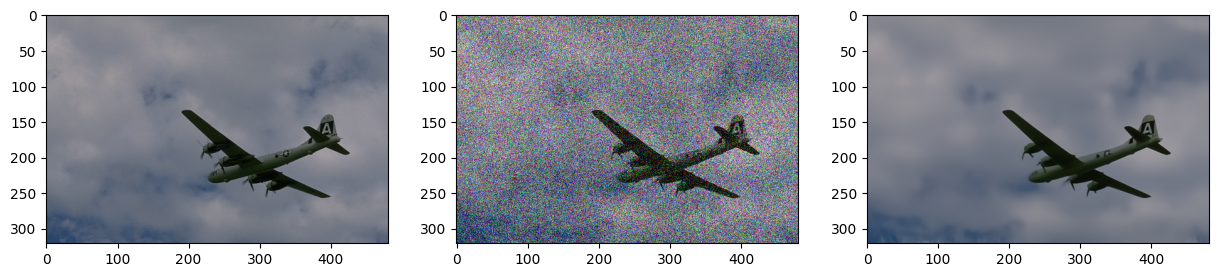

FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv psnr_testing=37.96036148071289
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/Kodak/1.png time=0.3057436943054199 test_i_psnr_value=27.171138763427734


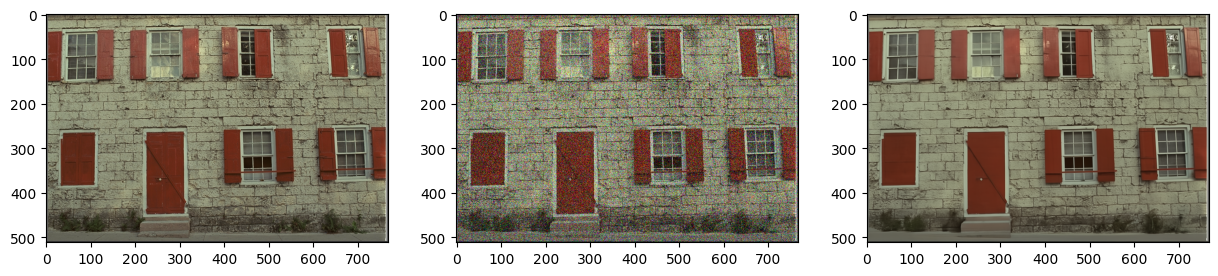

FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv psnr_testing=27.171138763427734
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/1.tif time=0.4007689952850342 test_i_psnr_value=26.481040954589844


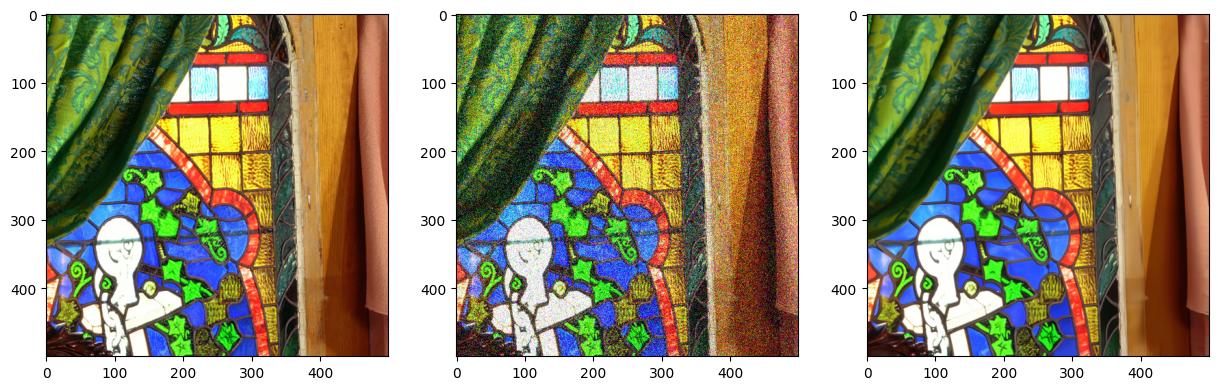

FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv psnr_testing=26.481040954589844
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/Urban100/img_001.png time=0.6913044452667236 test_i_psnr_value=30.591548919677734


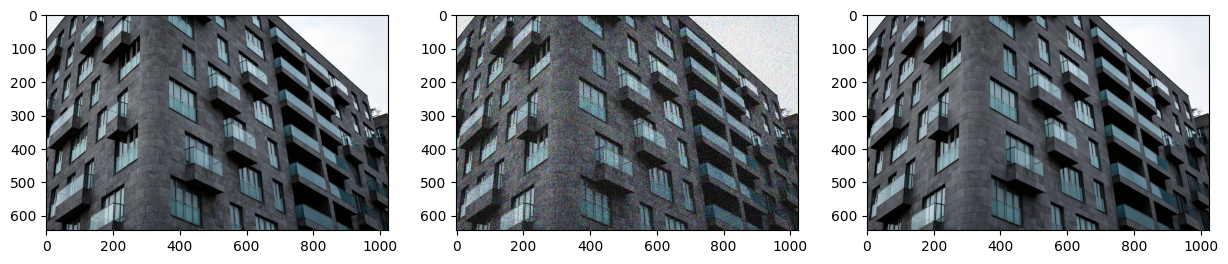

FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv psnr_testing=30.591548919677734


In [5]:

model.eval()
RESULT_ROOT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/exploration/model_multiscale_mixture_GLR/result_images"
MODEL_NAME = "Restormer"
TEST_PATHS = [
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv'
]


for test_path in TEST_PATHS:

    csv_path = os.path.join(test_path)
    img_infos = pd.read_csv(csv_path, index_col='index')


    paths = img_infos["path"].tolist()
    paths = [
        os.path.join(ROOT_DATASET,path)
        for path in paths
    ]

    SIGMA_TEST = 50.0
    factor = 16
    list_test_mse = []
    random_state = np.random.RandomState(seed=2204)
    test_i = 0
    s = time.time()
    for file_ in paths:
        torch.cuda.ipc_collect()
        torch.cuda.empty_cache()

        img = Image.open(file_)
        img_true_255 = np.array(img).astype(np.float32)
        img_true = img_true_255 / 255.0

        noisy_img_raw = img_true.copy()
        noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
        # noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

        noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
        noisy_img = noisy_img.unsqueeze(0)

        h,w = noisy_img.shape[2], noisy_img.shape[3]
        H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
        padh = H-h if h%factor!=0 else 0
        padw = W-w if w%factor!=0 else 0
        noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

        with torch.no_grad():
            restored = model(noisy_img.to(DEVICE))

        restored = restored[:,:,:h,:w]
        restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

        restored = img_as_ubyte(restored).astype(np.float32)
        test_mse_value = np.square(img_true_255- restored).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={file_} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
        test_i += 1
        s = time.time()

        # SAVE IMAGES RESULT
        filename = file_.split("/")[-1].split(".")[0]
        dataset_name = file_.split("/")[-2]
        denoised_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}_{3}_denoised.png".format(dataset_name, int(SIGMA_TEST), filename, MODEL_NAME)
        clean_img = img_true_255.astype(np.uint8)
        noise_img = img_as_ubyte(np.clip(noisy_img_raw, 0, 1)).astype(np.uint8)
        denoised_img = restored.astype(np.uint8)
        # plt.imsave(denoised_img_path, denoised_img)
        
        fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))
        axs[0].imshow(clean_img)
        axs[1].imshow(noise_img)
        axs[2].imshow(denoised_img)
        plt.show()
        break
        
    psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
    print(f"FINISH TESTING path={test_path} psnr_testing={np.mean(psnr_testing)}")


# Sigma = 25 REstormer

In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import cv2
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
import baselineRestormer as model_structure
pd.set_option('display.max_colwidth', None)


In [2]:
CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_restormer/papers_checkpoints/")
model = model_structure.Restormer(
    inp_channels=3,
    out_channels=3,
    dim=48,
    num_blocks=[4,6,6,8],
    num_refinement_blocks=4,
    heads=[1,2,4,8],
    ffn_expansion_factor=2.66,
    bias=False,
    LayerNorm_type="BiasFree",
    dual_pixel_task=False
).to(DEVICE)
training_state_path = os.path.join(CHECKPOINT_DIR, 'gaussian_color_denoising_sigma25.pth')
training_state = torch.load(training_state_path, weights_only=False)
model.load_state_dict({k:p.to(DEVICE) for k, p in training_state["params"].items()})
model.eval()

s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

print(f"Init model with total parameters: {s}")

Init model with total parameters: 26111668


In [3]:
import torch
from torch.utils.flop_counter import FlopCounterMode

def get_flops(model, inp, with_backward=False):
    
    istrain = model.training
    model.eval()
    
    inp = inp if isinstance(inp, torch.Tensor) else torch.randn(inp)

    flop_counter = FlopCounterMode(mods=model, display=False, depth=None)
    with flop_counter:
        if with_backward:
            model(inp).sum().backward()
        else:
            model(inp)
    total_flops =  flop_counter.get_total_flops()
    if istrain:
        model.train()
    return total_flops

SIGMA_TEST = 25.0
factor = 16
random_state = np.random.RandomState(seed=2204)

img = Image.open("/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png")
img_true_255 = np.array(img).astype(np.float32)
img_true = img_true_255 / 255.0

noisy_img_raw = img_true.copy()
noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
# noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
noisy_img = noisy_img.unsqueeze(0)

h,w = noisy_img.shape[2], noisy_img.shape[3]
H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
padh = H-h if h%factor!=0 else 0
padw = W-w if w%factor!=0 else 0
noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

flops = get_flops(model, noisy_img.to(DEVICE))

print(f"flops= {flops/1e9}")


s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

print(f"Init model with total parameters: {s}")

/tmp/ipykernel_595991/4220572293.py:11: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(mods=model, display=False, depth=None)


flops= 787.720332672
Init model with total parameters: 26111668


In [8]:

model.eval()
RESULT_ROOT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/exploration/model_multiscale_mixture_GLR/result_images"
MODEL_NAME = "Restormer"
TEST_PATHS = [
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv'
]


for test_path in TEST_PATHS:

    csv_path = os.path.join(test_path)
    img_infos = pd.read_csv(csv_path, index_col='index')


    paths = img_infos["path"].tolist()
    paths = [
        os.path.join(ROOT_DATASET,path)
        for path in paths
    ]

    SIGMA_TEST = 25.0
    factor = 16
    list_test_mse = []
    random_state = np.random.RandomState(seed=2204)
    test_i = 0
    s = time.time()
    for file_ in paths:
        torch.cuda.ipc_collect()
        torch.cuda.empty_cache()

        img = Image.open(file_)
        img_true_255 = np.array(img).astype(np.float32)
        img_true = img_true_255 / 255.0

        noisy_img_raw = img_true.copy()
        noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
        # noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

        noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
        noisy_img = noisy_img.unsqueeze(0)

        h,w = noisy_img.shape[2], noisy_img.shape[3]
        H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
        padh = H-h if h%factor!=0 else 0
        padw = W-w if w%factor!=0 else 0
        noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

        with torch.no_grad():
            restored = model(noisy_img.to(DEVICE))

        restored = restored[:,:,:h,:w]
        restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

        restored = img_as_ubyte(restored).astype(np.float32)
        test_mse_value = np.square(img_true_255- restored).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={file_} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
        test_i += 1
        s = time.time()

        # SAVE IMAGES RESULT
        filename = file_.split("/")[-1].split(".")[0]
        dataset_name = file_.split("/")[-2]
        denoised_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}_{3}_denoised.png".format(dataset_name, int(SIGMA_TEST), filename, MODEL_NAME)
        clean_img = img_true_255.astype(np.uint8)
        noise_img = img_as_ubyte(np.clip(noisy_img_raw, 0, 1)).astype(np.uint8)
        denoised_img = restored.astype(np.uint8)
        plt.imsave(denoised_img_path, denoised_img)
        
        # fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))
        # axs[0].imshow(clean_img)
        # axs[1].imshow(noise_img)
        # axs[2].imshow(denoised_img)
        # plt.show()
        # break
        
    psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
    print(f"FINISH TESTING path={test_path} psnr_testing={np.mean(psnr_testing)}")


test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png time=0.2254314422607422 test_i_psnr_value=40.81594467163086
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0001.png time=0.29906463623046875 test_i_psnr_value=30.5886287689209
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0002.png time=0.2896459102630615 test_i_psnr_value=35.086856842041016
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0003.png time=0.29967331886291504 test_i_psnr_value=30.936662673950195
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0004.png time=0.2979905605316162 test_i_psnr_value=30.610349655151367
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0005.png time=0.3234670162200928 test_i_psnr_value=31.91960906982422
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/C

# Sigma = 25 LGPUnroll

In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import cv2
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
import model_GLR_GTV_deep_v13 as model_structure
pd.set_option('display.max_colwidth', None)


In [2]:
# checkpoints_epoch00_iter0695k sigma 15
# checkpoints_epoch00_iter0795k sigma 25
# checkpoints_epoch00_iter0625k sigma 50

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test31_v13_sigma25/checkpoints/")
model = model_structure.AbtractMultiScaleGraphFilter(
    n_channels_in=3, 
    n_channels_out=3, 
    dims=[48, 96, 192, 384],
    hidden_dims=[96, 192, 384, 768],
    nsubnets=[1, 1, 1, 1],
    ngraphs=[8, 16, 16, 32], #[1, 2, 4, 8], 
    num_blocks=[4, 6, 6, 8], 
    num_blocks_out=4
).to(DEVICE)
training_state_path = os.path.join(CHECKPOINT_DIR, 'checkpoints_epoch00_iter0795k.pt')
training_state = torch.load(training_state_path, weights_only=False)
model.load_state_dict({k:p.to(DEVICE) for k, p in training_state["model"].items()})
model.eval()



AbtractMultiScaleGraphFilter(
  (patch_3x3_embeding): ReginalPixelEmbeding(
    (channels_local_linear_op01): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  )
  (encoder_scale_00): Sequential(
    (0): LocalNonLinearBlock(
      (norm): CustomLayerNorm(
        (weighted_transform): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), groups=48, bias=False)
      )
      (local_linear): LocalGatedLinearBlock(
        (channels_linear_op): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (channels_local_linear_op): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False, padding_mode=replicate)
        (project_out): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): LocalNonLinearBlock(
      (norm): CustomLayerNorm(
        (weighted_transform): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), groups=48, bias=False)
      )
      (local_linea

In [3]:
import torch
from torch.utils.flop_counter import FlopCounterMode

def get_flops(model, inp, with_backward=False):
    
    istrain = model.training
    model.eval()
    
    inp = inp if isinstance(inp, torch.Tensor) else torch.randn(inp)

    flop_counter = FlopCounterMode(mods=model, display=False, depth=None)
    with flop_counter:
        if with_backward:
            model(inp).sum().backward()
        else:
            model(inp)
    total_flops =  flop_counter.get_total_flops()
    if istrain:
        model.train()
    return total_flops

SIGMA_TEST = 25.0
factor = 16
random_state = np.random.RandomState(seed=2204)

img = Image.open("/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png")
img_true_255 = np.array(img).astype(np.float32)
img_true = img_true_255 / 255.0

noisy_img_raw = img_true.copy()
noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
# noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
noisy_img = noisy_img.unsqueeze(0)

h,w = noisy_img.shape[2], noisy_img.shape[3]
H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
padh = H-h if h%factor!=0 else 0
padw = W-w if w%factor!=0 else 0
noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

flops = get_flops(model, noisy_img.to(DEVICE))

print(f"flops= {flops/1e9}")


/tmp/ipykernel_593029/3303114936.py:11: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(mods=model, display=False, depth=None)


flops= 246.966193152


In [4]:

model.eval()
RESULT_ROOT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/exploration/model_multiscale_mixture_GLR/result_images"
MODEL_NAME = "LGPUnrol"
TEST_PATHS = [
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv'
]


for test_path in TEST_PATHS:

    csv_path = os.path.join(test_path)
    img_infos = pd.read_csv(csv_path, index_col='index')


    paths = img_infos["path"].tolist()
    paths = [
        os.path.join(ROOT_DATASET,path)
        for path in paths
    ]

    SIGMA_TEST = 25.0
    factor = 16
    list_test_mse = []
    random_state = np.random.RandomState(seed=2204)
    test_i = 0
    s = time.time()
    for file_ in paths:
        torch.cuda.ipc_collect()
        torch.cuda.empty_cache()

        img = Image.open(file_)
        img_true_255 = np.array(img).astype(np.float32)
        img_true = img_true_255 / 255.0

        noisy_img_raw = img_true.copy()
        noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
        # noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

        noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
        noisy_img = noisy_img.unsqueeze(0)

        h,w = noisy_img.shape[2], noisy_img.shape[3]
        H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
        padh = H-h if h%factor!=0 else 0
        padw = W-w if w%factor!=0 else 0
        noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

        with torch.no_grad():
            restored = model(noisy_img.to(DEVICE))

        restored = restored[:,:,:h,:w]
        restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

        restored = img_as_ubyte(restored).astype(np.float32)
        test_mse_value = np.square(img_true_255- restored).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={file_} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
        test_i += 1
        s = time.time()

        # SAVE IMAGES RESULT
        filename = file_.split("/")[-1].split(".")[0]
        dataset_name = file_.split("/")[-2]
        noisy_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}.png".format(dataset_name, int(SIGMA_TEST), filename)
        denoised_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}_{3}_denoised.png".format(dataset_name, int(SIGMA_TEST), filename, MODEL_NAME)
        clean_img = img_true_255.astype(np.uint8)
        noise_img = img_as_ubyte(np.clip(noisy_img_raw, 0, 1)).astype(np.uint8)
        denoised_img = restored.astype(np.uint8)
        plt.imsave(noisy_img_path, noise_img)
        plt.imsave(denoised_img_path, denoised_img)
        
        # fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))
        # axs[0].imshow(clean_img)
        # axs[1].imshow(noise_img)
        # axs[2].imshow(denoised_img)
        # plt.show()

    psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
    print(f"FINISH TESTING path={test_path} psnr_testing={np.mean(psnr_testing)}")


test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png time=1.112987756729126 test_i_psnr_value=40.654335021972656
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0001.png time=0.695000410079956 test_i_psnr_value=30.46282196044922
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0002.png time=0.8691911697387695 test_i_psnr_value=34.994529724121094
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0003.png time=0.8800554275512695 test_i_psnr_value=30.873916625976562
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0004.png time=0.899893045425415 test_i_psnr_value=30.536582946777344
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0005.png time=0.9028487205505371 test_i_psnr_value=31.781370162963867
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBS

# Sigma = 50 LGPUnroll

In [4]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import cv2
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
import model_GLR_GTV_deep_v13 as model_structure
pd.set_option('display.max_colwidth', None)


In [5]:
# checkpoints_epoch00_iter0695k sigma 15
# checkpoints_epoch00_iter0795k sigma 25
# checkpoints_epoch00_iter0625k sigma 50

CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_test31_v13_sigma50/checkpoints/")
model = model_structure.AbtractMultiScaleGraphFilter(
    n_channels_in=3, 
    n_channels_out=3, 
    dims=[48, 96, 192, 384],
    hidden_dims=[96, 192, 384, 768],
    nsubnets=[1, 1, 1, 1],
    ngraphs=[8, 16, 16, 32], #[1, 2, 4, 8], 
    num_blocks=[4, 6, 6, 8], 
    num_blocks_out=4
).to(DEVICE)
training_state_path = os.path.join(CHECKPOINT_DIR, 'checkpoints_epoch00_iter0625k.pt')
training_state = torch.load(training_state_path, weights_only=False)
model.load_state_dict({k:p.to(DEVICE) for k, p in training_state["model"].items()})
model.eval()



AbtractMultiScaleGraphFilter(
  (patch_3x3_embeding): ReginalPixelEmbeding(
    (channels_local_linear_op01): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=replicate)
  )
  (encoder_scale_00): Sequential(
    (0): LocalNonLinearBlock(
      (norm): CustomLayerNorm(
        (weighted_transform): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), groups=48, bias=False)
      )
      (local_linear): LocalGatedLinearBlock(
        (channels_linear_op): Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (channels_local_linear_op): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False, padding_mode=replicate)
        (project_out): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): LocalNonLinearBlock(
      (norm): CustomLayerNorm(
        (weighted_transform): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), groups=48, bias=False)
      )
      (local_linea

In [6]:

model.eval()
RESULT_ROOT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/exploration/model_multiscale_mixture_GLR/result_images"
MODEL_NAME = "LGPUnrol"
TEST_PATHS = [
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv'
]


for test_path in TEST_PATHS:

    csv_path = os.path.join(test_path)
    img_infos = pd.read_csv(csv_path, index_col='index')


    paths = img_infos["path"].tolist()
    paths = [
        os.path.join(ROOT_DATASET,path)
        for path in paths
    ]

    SIGMA_TEST = 15.0
    factor = 16
    list_test_mse = []
    random_state = np.random.RandomState(seed=2204)
    test_i = 0
    s = time.time()
    for file_ in paths:
        torch.cuda.ipc_collect()
        torch.cuda.empty_cache()

        img = Image.open(file_)
        img_true_255 = np.array(img).astype(np.float32)
        img_true = img_true_255 / 255.0

        noisy_img_raw = img_true.copy()
        noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
        # noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

        noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
        noisy_img = noisy_img.unsqueeze(0)

        h,w = noisy_img.shape[2], noisy_img.shape[3]
        H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
        padh = H-h if h%factor!=0 else 0
        padw = W-w if w%factor!=0 else 0
        noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

        with torch.no_grad():
            restored = model(noisy_img.to(DEVICE))

        restored = restored[:,:,:h,:w]
        restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

        restored = img_as_ubyte(restored).astype(np.float32)
        test_mse_value = np.square(img_true_255- restored).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={file_} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
        test_i += 1
        s = time.time()

        # SAVE IMAGES RESULT
        filename = file_.split("/")[-1].split(".")[0]
        dataset_name = file_.split("/")[-2]
        noisy_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}.png".format(dataset_name, int(SIGMA_TEST), filename)
        denoised_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}_{3}_denoised.png".format(dataset_name, int(SIGMA_TEST), filename, MODEL_NAME)
        clean_img = img_true_255.astype(np.uint8)
        noise_img = img_as_ubyte(np.clip(noisy_img_raw, 0, 1)).astype(np.uint8)
        denoised_img = restored.astype(np.uint8)
        # plt.imsave(noisy_img_path, noise_img)
        # plt.imsave(denoised_img_path, denoised_img)
        
        # fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))
        # axs[0].imshow(clean_img)
        # axs[1].imshow(noise_img)
        # axs[2].imshow(denoised_img)
        # plt.show()
        # break

    psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
    print(f"FINISH TESTING path={test_path} psnr_testing={np.mean(psnr_testing)}")


test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png time=0.5106303691864014 test_i_psnr_value=38.51482009887695
FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv psnr_testing=38.51482009887695
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/Kodak/1.png time=0.6982691287994385 test_i_psnr_value=27.530641555786133
FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv psnr_testing=27.530641555786133
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/McMaster/1.tif time=0.5661745071411133 test_i_psnr_value=26.320247650146484
FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv psnr_testing=26.320247650146484
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/Urban100/img_001.png time=0.8221704959869385 test_i_p

In [ ]:
# Sigma=15
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv psnr_testing=34.278141021728516, 34.28
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv psnr_testing=35.286128997802734, 35.29
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv psnr_testing=35.3376579284668, 35.34
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv psnr_testing=34.788917541503906, 34.79

# Sigma=25
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv psnr_testing=31.658166885375977, 31.66
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv psnr_testing=32.87141799926758, 32.87
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv psnr_testing=33.079010009765625, 33.08
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv psnr_testing=32.550636291503906, 32.55

# Sigma=50
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv psnr_testing=28.43894386291504, 28.44
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv psnr_testing=29.825185775756836, 29.83
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv psnr_testing=29.97946548461914, 29.98
# FINISH TESTING path=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv psnr_testing=29.4398193359375, 29.44

# Sigma 25 SiwnIR

In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import cv2
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
import baselineSwinSR as model_structure
pd.set_option('display.max_colwidth', None)


/home/jovyan/shared/Thuc/hoodsgatedrive/envs/working2025_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/shared/Thuc/hoodsgatedrive/envs/working2025_pytorch/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_swinIR/paper_checkpoints/")
model = model_structure.SwinIR(
    upscale=1, in_chans=3, img_size=128, window_size=8,
    img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
    mlp_ratio=2, upsampler='', resi_connection='1conv'
).to(DEVICE)
training_state_path = os.path.join(CHECKPOINT_DIR, '005_colorDN_DFWB_s128w8_SwinIR-M_noise25.pth')
training_state = torch.load(training_state_path, weights_only=False)
model.load_state_dict({k:p.to(DEVICE) for k, p in training_state["params"].items()})
model.eval()


s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

print(f"Init model with total parameters: {s}")

/home/jovyan/shared/Thuc/hoodsgatedrive/envs/working2025_pytorch/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Init model with total parameters: 11504163


In [3]:
import torch
from torch.utils.flop_counter import FlopCounterMode

def get_flops(model, inp, with_backward=False):
    
    istrain = model.training
    model.eval()
    
    inp = inp if isinstance(inp, torch.Tensor) else torch.randn(inp)

    flop_counter = FlopCounterMode(mods=model, display=False, depth=None)
    with flop_counter:
        if with_backward:
            model(inp).sum().backward()
        else:
            model(inp)
    total_flops =  flop_counter.get_total_flops()
    if istrain:
        model.train()
    return total_flops

SIGMA_TEST = 25.0
factor = 16
random_state = np.random.RandomState(seed=2204)

img = Image.open("/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png")
img_true_255 = np.array(img).astype(np.float32)
img_true = img_true_255 / 255.0

noisy_img_raw = img_true.copy()
noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
# noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
noisy_img = noisy_img.unsqueeze(0)

h,w = noisy_img.shape[2], noisy_img.shape[3]
H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
padh = H-h if h%factor!=0 else 0
padw = W-w if w%factor!=0 else 0
noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

flops = get_flops(model, noisy_img.to(DEVICE))

print(f"flops= {flops/1e9}")


/tmp/ipykernel_594193/3303114936.py:11: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(mods=model, display=False, depth=None)


flops= 4070.25948672


In [ ]:

model.eval()
RESULT_ROOT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/exploration/model_multiscale_mixture_GLR/result_images"
MODEL_NAME = "SwinIR"
TEST_PATHS = [
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv'
]


for test_path in TEST_PATHS:

    csv_path = os.path.join(test_path)
    img_infos = pd.read_csv(csv_path, index_col='index')


    paths = img_infos["path"].tolist()
    paths = [
        os.path.join(ROOT_DATASET,path)
        for path in paths
    ]

    SIGMA_TEST = 25.0
    factor = 16
    list_test_mse = []
    list_time_ops = []
    random_state = np.random.RandomState(seed=2204)
    test_i = 0
    for file_ in paths:
        torch.cuda.ipc_collect()
        torch.cuda.empty_cache()

        img = Image.open(file_)
        img_true_255 = np.array(img).astype(np.float32)
        img_true = img_true_255 / 255.0

        noisy_img_raw = img_true.copy()
        noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
        # noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

        noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
        noisy_img = noisy_img.unsqueeze(0)

        h,w = noisy_img.shape[2], noisy_img.shape[3]
        H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
        padh = H-h if h%factor!=0 else 0
        padw = W-w if w%factor!=0 else 0
        noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

        
        s = time.time()
        with torch.no_grad():
            restored = model(noisy_img.to(DEVICE))
        time_cost = time.time() - s
        list_time_ops.append(time_cost)
        
        restored = restored[:,:,:h,:w]
        restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

        restored = img_as_ubyte(restored).astype(np.float32)
        test_mse_value = np.square(img_true_255- restored).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={file_} time={time_cost} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
        test_i += 1
        s = time.time()

        # SAVE IMAGES RESULT
        filename = file_.split("/")[-1].split(".")[0]
        dataset_name = file_.split("/")[-2]
        denoised_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}_{3}_denoised.png".format(dataset_name, int(SIGMA_TEST), filename, MODEL_NAME)
        clean_img = img_true_255.astype(np.uint8)
        noise_img = img_as_ubyte(np.clip(noisy_img_raw, 0, 1)).astype(np.uint8)
        denoised_img = restored.astype(np.uint8)
        plt.imsave(denoised_img_path, denoised_img)
        
        # fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))
        # axs[0].imshow(clean_img)
        # axs[1].imshow(noise_img)
        # axs[2].imshow(denoised_img)
        # plt.show()
        # break
        
    psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
    print(f"FINISH TESTING path={test_path} psnr_testing={np.mean(psnr_testing)} time_cost_avg={np.mean(list_time_ops)}")


test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png time=1.6253464221954346 test_i_psnr_value=40.737548828125
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0001.png time=0.12710952758789062 test_i_psnr_value=30.580585479736328
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0002.png time=0.12735486030578613 test_i_psnr_value=35.076263427734375
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0003.png time=0.1267995834350586 test_i_psnr_value=30.9385986328125
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0004.png time=0.1253368854522705 test_i_psnr_value=30.615110397338867
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0005.png time=0.12975764274597168 test_i_psnr_value=31.923538208007812
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/C

In [6]:
np.mean(list_time_ops)

np.float64(0.8744598340988159)

# Sigma=50 SwinIR

In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import cv2
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib'))
import baselineSwinSR as model_structure
pd.set_option('display.max_colwidth', None)


/home/jovyan/shared/Thuc/hoodsgatedrive/envs/working2025_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jovyan/shared/Thuc/hoodsgatedrive/envs/working2025_pytorch/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_swinIR/paper_checkpoints/")
model = model_structure.SwinIR(
    upscale=1, in_chans=3, img_size=128, window_size=8,
    img_range=1., depths=[6, 6, 6, 6, 6, 6], embed_dim=180, num_heads=[6, 6, 6, 6, 6, 6],
    mlp_ratio=2, upsampler='', resi_connection='1conv'
).to(DEVICE)
training_state_path = os.path.join(CHECKPOINT_DIR, '005_colorDN_DFWB_s128w8_SwinIR-M_noise50.pth')
training_state = torch.load(training_state_path, weights_only=False)
model.load_state_dict({k:p.to(DEVICE) for k, p in training_state["params"].items()})
model.eval()
s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

print(f"Init model with total parameters: {s}")

Init model with total parameters: 11504163


In [5]:

model.eval()
RESULT_ROOT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/exploration/model_multiscale_mixture_GLR/result_images"
MODEL_NAME = "SwinIR"
TEST_PATHS = [
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv'
]


for test_path in TEST_PATHS:

    csv_path = os.path.join(test_path)
    img_infos = pd.read_csv(csv_path, index_col='index')


    paths = img_infos["path"].tolist()
    paths = [
        os.path.join(ROOT_DATASET,path)
        for path in paths
    ]

    SIGMA_TEST = 50.0
    factor = 16
    list_test_mse = []
    random_state = np.random.RandomState(seed=2204)
    test_i = 0
    s = time.time()
    for file_ in paths:
        torch.cuda.ipc_collect()
        torch.cuda.empty_cache()

        img = Image.open(file_)
        img_true_255 = np.array(img).astype(np.float32)
        img_true = img_true_255 / 255.0

        noisy_img_raw = img_true.copy()
        noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
        # noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

        noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
        noisy_img = noisy_img.unsqueeze(0)

        h,w = noisy_img.shape[2], noisy_img.shape[3]
        H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
        padh = H-h if h%factor!=0 else 0
        padw = W-w if w%factor!=0 else 0
        noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

        with torch.no_grad():
            restored = model(noisy_img.to(DEVICE))

        restored = restored[:,:,:h,:w]
        restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

        restored = img_as_ubyte(restored).astype(np.float32)
        test_mse_value = np.square(img_true_255- restored).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={file_} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
        test_i += 1
        s = time.time()

        # SAVE IMAGES RESULT
        filename = file_.split("/")[-1].split(".")[0]
        dataset_name = file_.split("/")[-2]
        denoised_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}_{3}_denoised.png".format(dataset_name, int(SIGMA_TEST), filename, MODEL_NAME)
        clean_img = img_true_255.astype(np.uint8)
        noise_img = img_as_ubyte(np.clip(noisy_img_raw, 0, 1)).astype(np.uint8)
        denoised_img = restored.astype(np.uint8)
        plt.imsave(denoised_img_path, denoised_img)
        
        # fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))
        # axs[0].imshow(clean_img)
        # axs[1].imshow(noise_img)
        # axs[2].imshow(denoised_img)
        # plt.show()
        # break
        
    psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
    print(f"FINISH TESTING path={test_path} psnr_testing={np.mean(psnr_testing)}")


test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png time=0.7611863613128662 test_i_psnr_value=37.75408172607422
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0001.png time=0.9429202079772949 test_i_psnr_value=27.193660736083984
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0002.png time=0.661872148513794 test_i_psnr_value=32.524497985839844
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0003.png time=0.8818187713623047 test_i_psnr_value=27.84897232055664
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0004.png time=0.6202836036682129 test_i_psnr_value=27.475473403930664
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0005.png time=0.8829090595245361 test_i_psnr_value=29.016952514648438
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CB

In [ ]:
#

# Sigma 25 and 50 DRUnet

In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
import cv2
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR, SequentialLR

#########################################################################################################
torch.set_float32_matmul_precision('high')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
ROOT_PROJECT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/"
ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

#########################################################################################################

sys.path.append(os.path.join(ROOT_PROJECT, 'exploration/model_multiscale_mixture_GLR/lib/baselineDRUnet'))
from network_unet import UNetRes
pd.set_option('display.max_colwidth', None)


In [2]:
CHECKPOINT_DIR = os.path.join(ROOT_PROJECT, "exploration/model_multiscale_mixture_GLR/result/model_DRUnet/checkpoints/")
model = UNetRes(
    in_nc=4, out_nc=3,
    nc=[64, 128, 256, 512],
    nb=4, act_mode='R', 
    downsample_mode="strideconv", upsample_mode="convtranspose"
).to(DEVICE)
training_state_path = os.path.join(CHECKPOINT_DIR, 'drunet_color.pth')
training_state      = torch.load(training_state_path, weights_only=False)
model.load_state_dict({k:p.to(DEVICE) for k, p in training_state.items()})
model.eval()
number_parameters = sum(map(lambda x: x.numel(), model.parameters()))
print('Params number: {}'.format(number_parameters))

Params number: 32640960


In [ ]:
import torch
from torch.utils.flop_counter import FlopCounterMode

def get_flops(model, inp, with_backward=False):
    
    istrain = model.training
    model.eval()
    
    inp = inp if isinstance(inp, torch.Tensor) else torch.randn(inp)

    flop_counter = FlopCounterMode(mods=model, display=False, depth=None)
    with flop_counter:
        if with_backward:
            model(inp).sum().backward()
        else:
            model(inp)
    total_flops =  flop_counter.get_total_flops()
    if istrain:
        model.train()
    return total_flops

SIGMA_TEST = 25.0
factor = 16
random_state = np.random.RandomState(seed=2204)

img = Image.open("/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png")
img_true_255 = np.array(img).astype(np.float32)
img_true = img_true_255 / 255.0

noisy_img_raw = img_true.copy()
noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
# noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
noisy_img = noisy_img.unsqueeze(0)
noisy_img = torch.cat((noisy_img, torch.FloatTensor([SIGMA_TEST/255.]).repeat(1, 1, noisy_img.shape[2], noisy_img.shape[3])), dim=1)

h,w = noisy_img.shape[2], noisy_img.shape[3]
H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
padh = H-h if h%factor!=0 else 0
padw = W-w if w%factor!=0 else 0
noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

flops = get_flops(model, noisy_img.to(DEVICE))

print(f"flops= {flops/1e9}")

s = 0
for p in model.parameters():
    s += np.prod(np.array(p.shape))
    # print(p.dtype, np.array(p.shape), s)

print(f"Init model with total parameters: {s}")

flops= 705.810825216
Init model with total parameters: 32640960


/tmp/ipykernel_589270/499822987.py:11: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(mods=model, display=False, depth=None)


In [11]:

model.eval()
RESULT_ROOT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/exploration/model_multiscale_mixture_GLR/result_images"
MODEL_NAME = "DRUnet"
TEST_PATHS = [
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv'
]


for test_path in TEST_PATHS:

    csv_path = os.path.join(test_path)
    img_infos = pd.read_csv(csv_path, index_col='index')


    paths = img_infos["path"].tolist()
    paths = [
        os.path.join(ROOT_DATASET,path)
        for path in paths
    ]

    SIGMA_TEST = 50.0
    factor = 16
    list_test_mse = []
    random_state = np.random.RandomState(seed=2204)
    test_i = 0
    s = time.time()
    for file_ in paths:
        torch.cuda.ipc_collect()
        torch.cuda.empty_cache()

        img = Image.open(file_)
        img_true_255 = np.array(img).astype(np.float32)
        img_true = img_true_255 / 255.0

        noisy_img_raw = img_true.copy()
        noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
        # noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

        noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
        noisy_img = noisy_img.unsqueeze(0)
        noisy_img = torch.cat((noisy_img, torch.FloatTensor([SIGMA_TEST/255.]).repeat(1, 1, noisy_img.shape[2], noisy_img.shape[3])), dim=1)

        h,w = noisy_img.shape[2], noisy_img.shape[3]
        H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
        padh = H-h if h%factor!=0 else 0
        padw = W-w if w%factor!=0 else 0
        noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

        with torch.no_grad():
            restored = model(noisy_img.to(DEVICE))

        restored = restored[:,:,:h,:w]
        restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

        restored = img_as_ubyte(restored).astype(np.float32)
        test_mse_value = np.square(img_true_255- restored).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={file_} time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
        test_i += 1
        s = time.time()

        # SAVE IMAGES RESULT
        filename = file_.split("/")[-1].split(".")[0]
        dataset_name = file_.split("/")[-2]
        denoised_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}_{3}_denoised.png".format(dataset_name, int(SIGMA_TEST), filename, MODEL_NAME)
        clean_img = img_true_255.astype(np.uint8)
        noise_img = img_as_ubyte(np.clip(noisy_img_raw, 0, 1)).astype(np.uint8)
        denoised_img = restored.astype(np.uint8)
        plt.imsave(denoised_img_path, denoised_img)
        
        # fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))
        # axs[0].imshow(clean_img)
        # axs[1].imshow(noise_img)
        # axs[2].imshow(denoised_img)
        # plt.show()
        # break
        
    psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
    print(f"FINISH TESTING path={test_path} psnr_testing={np.mean(psnr_testing)}")


test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png time=0.1755542755126953 test_i_psnr_value=37.66217041015625
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0001.png time=0.2980353832244873 test_i_psnr_value=27.118379592895508
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0002.png time=0.3764529228210449 test_i_psnr_value=32.45463562011719
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0003.png time=0.3097109794616699 test_i_psnr_value=27.803916931152344
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0004.png time=0.3093550205230713 test_i_psnr_value=27.39896583557129
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0005.png time=0.2839491367340088 test_i_psnr_value=28.938030242919922
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CB

# Visual 

In [4]:
"./model_multiscale_mixture_GLR/result_images/"

'./model_multiscale_mixture_GLR/result_images/'

In [8]:
image_paths = ["CBSD68_sigma25_0000.png", "CBSD68_sigma25_0000_DRUnet_denoised.png", "CBSD68_sigma25_0000_SwinIR_denoised.png", "CBSD68_sigma25_0000_Restormer_denoised.png", "CBSD68_sigma25_0000_LGPUnrol_denoised.png"]
image_paths = ["./model_multiscale_mixture_GLR/result_images/" + p for p in image_paths] + ["/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png"]
titles = ['Input Noisy Image', 'DRUnet', 'SwinIR', 'Restormer', 'LGPUnrol', "True Image"]

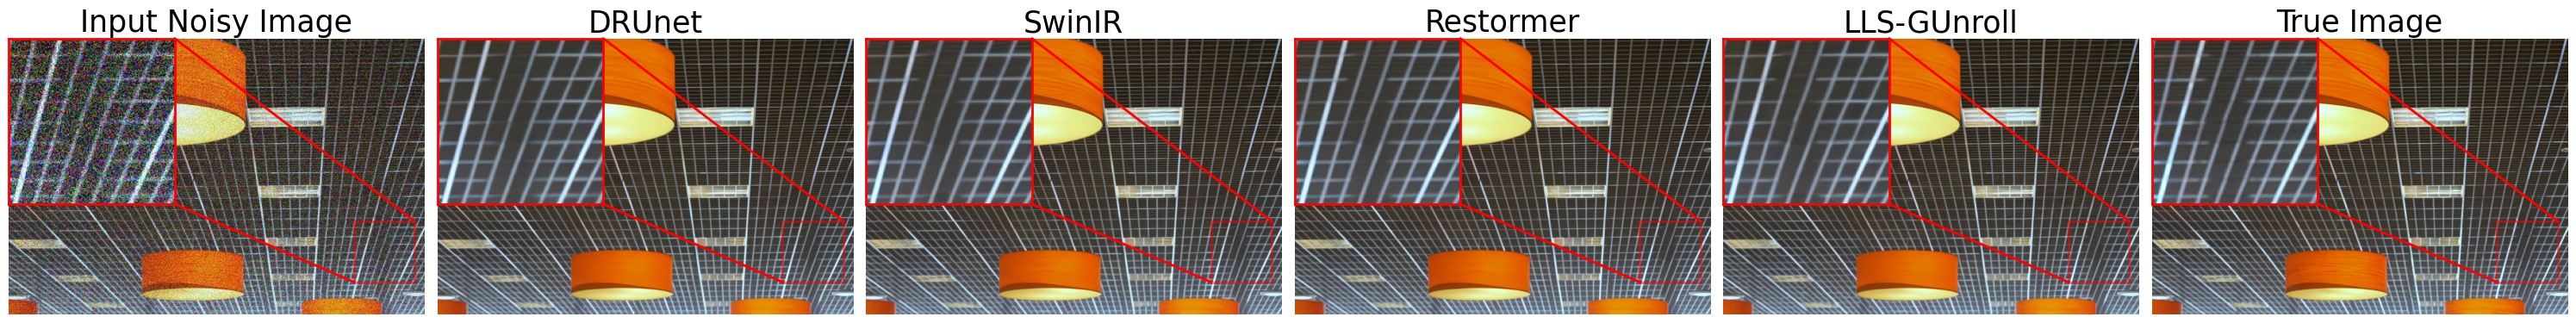

In [88]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

### TEST IMG 01
dataset_name= "Urban100"
Image_ID = "img_044"
image_paths = [f"{dataset_name}_sigma50_{Image_ID}.png", f"{dataset_name}_sigma50_{Image_ID}_DRUnet_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_SwinIR_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_Restormer_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_LGPUnrol_denoised.png"]
image_paths = ["./model_multiscale_mixture_GLR/result_images/" + p for p in image_paths] + [f"/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/{dataset_name}/{Image_ID}.png"]
x, y = (850, 450)


# dataset_name= "Kodak"
# Image_ID = "23"
# image_paths = [f"{dataset_name}_sigma50_{Image_ID}.png", f"{dataset_name}_sigma50_{Image_ID}_DRUnet_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_SwinIR_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_Restormer_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_LGPUnrol_denoised.png"]
# image_paths = ["./model_multiscale_mixture_GLR/result_images/" + p for p in image_paths] + [f"/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/{dataset_name}/{Image_ID}.tif"]
# x, y = (300, 600)


# Region of interest (ROI) for zoom-in (example coordinates in pixels)
titles = ['Input Noisy Image', 'DRUnet', 'SwinIR', 'Restormer', 'LLS-GUnroll', "True Image"]
roi = [x, x+150, y, y+150]  # [x_min, x_max, y_min, y_max]

# Create a 4x1 subplot grid
fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(30, 5))
axes = axes.ravel()

for i, (img_path, title) in enumerate(zip(image_paths, titles)):
    # Load and display the main image
    img = mpimg.imread(img_path)
    axes[i].imshow(img, origin="upper")
    axes[i].set_title(title, fontsize=25)
    axes[i].axis('off')

    # Create inset axes (e.g., top-right corner, 40% of main axes size)
    # inset_ax = inset_axes(axes[i], width="50%", height="50%", loc='upper right')
    inset_ax = axes[i].inset_axes(
        [-0.1, 0.4, 0.6, 0.6],
        xlim=(roi[0], roi[1]), ylim=(roi[3], roi[2]), 
        xticklabels=[], 
        yticklabels=[]
    )
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        inset_ax.spines[axis].set_linewidth(2)
        inset_ax.spines[axis].set_color("red")

    inset_ax.imshow(img, origin="lower")
    # axes[i].indicate_inset_zoom(inset_ax, edgecolor="red", linewidth=2)
    
    rect = (roi[0], roi[2], roi[1] - roi[0], roi[3] - roi[2])

    box = axes[i].indicate_inset(rect, edgecolor="red", linewidth=2)

    cp1 = ConnectionPatch(xyA=(roi[1], roi[2]), xyB=(1, 1), axesA=axes[i], axesB=inset_ax,
                        coordsA="data", coordsB="axes fraction", edgecolor="red", linewidth=2)
    cp2 = ConnectionPatch(xyA=(roi[0], roi[3]), xyB=(1, 0), axesA=axes[i], axesB=inset_ax,
                        coordsA="data", coordsB="axes fraction", edgecolor="red", linewidth=2)

    axes[i].add_patch(cp1)
    axes[i].add_patch(cp2)

# Adjust layout to minimize padding
plt.tight_layout()

# Save the figure in high resolution
# plt.savefig('comparison_with_insets.pdf', dpi=300, bbox_inches='tight')
plt.show()

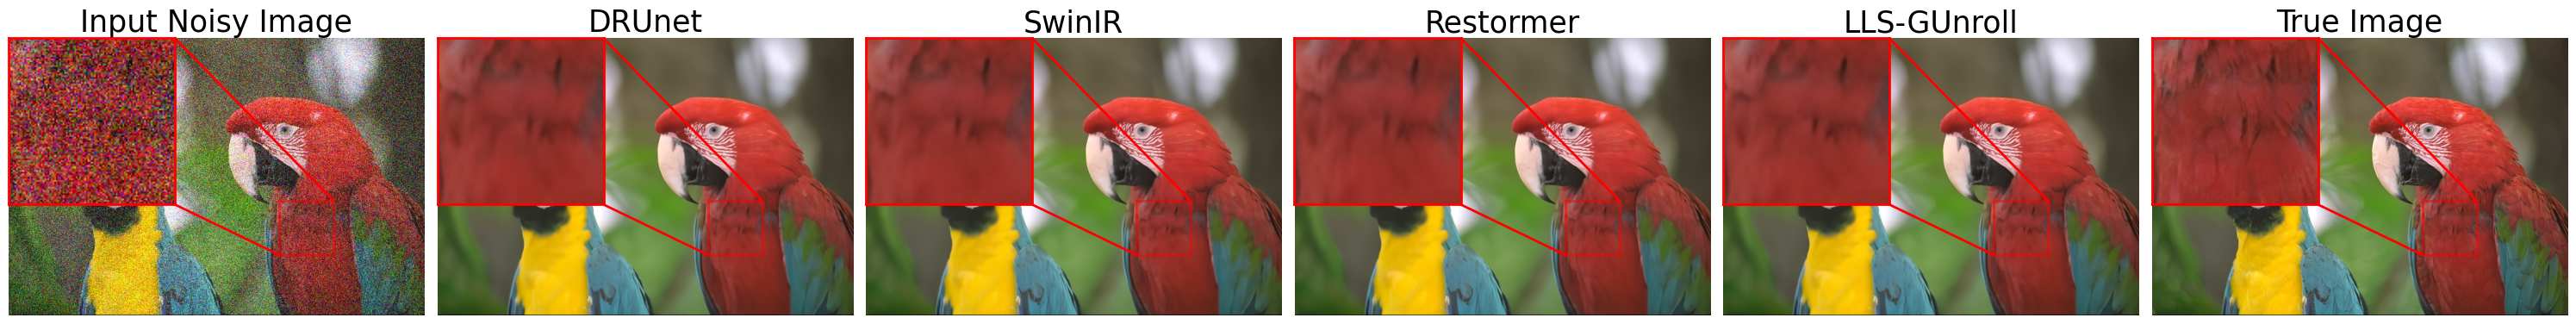

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

### TEST IMG 01
# dataset_name= "Urban100"
# Image_ID = "img_044"
# image_paths = [f"{dataset_name}_sigma50_{Image_ID}.png", f"{dataset_name}_sigma50_{Image_ID}_DRUnet_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_SwinIR_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_Restormer_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_LGPUnrol_denoised.png"]
# image_paths = ["./model_multiscale_mixture_GLR/result_images/" + p for p in image_paths] + [f"/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/{dataset_name}/{Image_ID}.png"]
# x, y = (500, 300)


dataset_name= "Kodak"
Image_ID = "23"
image_paths = [f"{dataset_name}_sigma50_{Image_ID}.png", f"{dataset_name}_sigma50_{Image_ID}_DRUnet_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_SwinIR_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_Restormer_denoised.png", f"{dataset_name}_sigma50_{Image_ID}_LGPUnrol_denoised.png"]
image_paths = ["./model_multiscale_mixture_GLR/result_images/" + p for p in image_paths] + [f"/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/{dataset_name}/{Image_ID}.png"]
x, y = (500, 300)


# Region of interest (ROI) for zoom-in (example coordinates in pixels)
titles = ['Input Noisy Image', 'DRUnet', 'SwinIR', 'Restormer', 'LLS-GUnroll', "True Image"]
roi = [x, x+100, y, y+100]  # [x_min, x_max, y_min, y_max]

# Create a 4x1 subplot grid
fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(30, 5))
axes = axes.ravel()

for i, (img_path, title) in enumerate(zip(image_paths, titles)):
    # Load and display the main image
    
    img = mpimg.imread(img_path)

    axes[i].imshow(img, origin="upper")
    axes[i].set_title(title, fontsize=25)
    axes[i].axis('off')

    # Create inset axes (e.g., top-right corner, 40% of main axes size)
    # inset_ax = inset_axes(axes[i], width="50%", height="50%", loc='upper right')
    inset_ax = axes[i].inset_axes(
        [-0.1, 0.4, 0.6, 0.6],
        xlim=(roi[0], roi[1]), ylim=(roi[3], roi[2]), 
        xticklabels=[], 
        yticklabels=[]
    )
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        inset_ax.spines[axis].set_linewidth(2)
        inset_ax.spines[axis].set_color("red")

    inset_ax.imshow(img, origin="lower")
    # axes[i].indicate_inset_zoom(inset_ax, edgecolor="red", linewidth=2)


    rect = (roi[0], roi[2], roi[1] - roi[0], roi[3] - roi[2])

    box = axes[i].indicate_inset(rect, edgecolor="red", linewidth=2)

    cp1 = ConnectionPatch(xyA=(roi[1], roi[2]), xyB=(1, 1), axesA=axes[i], axesB=inset_ax,
                        coordsA="data", coordsB="axes fraction", edgecolor="red", linewidth=2)
    cp2 = ConnectionPatch(xyA=(roi[0], roi[3]), xyB=(1, 0), axesA=axes[i], axesB=inset_ax,
                        coordsA="data", coordsB="axes fraction", edgecolor="red", linewidth=2)

    axes[i].add_patch(cp1)
    axes[i].add_patch(cp2)


# Adjust layout to minimize padding
plt.tight_layout()

# Save the figure in high resolution
# plt.savefig('comparison_with_insets.pdf', dpi=300, bbox_inches='tight')
plt.show()